<a href="https://colab.research.google.com/github/ykitaguchi77/CongenitalGlaucoma_AI_project/blob/main/EfficientNetv2_training_to_streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data_split for one-subject-leave-out stratified 5-fold crossvalidation**

for streamlit app

In [ ]:
"""
Leave one subject out cross validation + 5-fold stratified cross validation

・1症例を抜き出し、その症例のすべての画像をテスト画像とする
・残りの症例の内斜視、外斜視、斜視なし群を、同じ症例が群をまたがないように5分割する。
・5分割したデータセットのうち4つをtraining、1つをvalidationとして用いてトレーニングを行い、抜き出した1症例のそれぞれの画像のおける正解率を算出する。これを5回繰り返してcross validationとする。

"""

'\nLeave one subject out cross validation + 5-fold stratified cross validation\n\n・1症例を抜き出し、その症例のすべての画像をテスト画像とする\n・残りの症例の内斜視、外斜視、斜視なし群を、同じ症例が群をまたがないように5分割する。\n・5分割したデータセットのうち4つをtraining、1つをvalidationとして用いてトレーニングを行い、抜き出した1症例のそれぞれの画像のおける正解率を算出する。これを5回繰り返してcross validationとする。\n\n'

In [5]:
import codecs
import pandas as pd
import os
import numpy as np
import random
import shutil
import re
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
import pandas as pd
from PIL import Image
import tempfile
import time
import glob
import copy
import pickle
import itertools
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import timm

random_seed = 2 #shuffleのシード



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows', 500)


gla_ortho_path = r"H:\先天性緑内障\dataset_250px\gla_ortho"
gla_eso_path = r"H:\先天性緑内障\dataset_250px\gla_eso"
gla_exo_path = r"H:\先天性緑内障\dataset_250px\gla_exo"
cont_ortho_path = r"H:\先天性緑内障\dataset_250px\cont_ortho"
cont_eso_path = r"H:\先天性緑内障\dataset_250px\cont_eso"
cont_exo_path = r"H:\先天性緑内障\dataset_250px\cont_exo"
result_csv_path = r"H:\先天性緑内障\result.csv"
gradCAM_path = r"H:\先天性緑内障\gradcam_RepVGG"

pretrained_path = r"H:\先天性緑内障\RepVGG-A2.pth"


"""
gla_ortho_path = r"H:\先天性緑内障\データ引継ぎ\children_d"
gla_eso_path = r"H:\先天性緑内障\データ引継ぎ\children_d__内斜視"
gla_exo_path = r"H:\先天性緑内障\データ引継ぎ\children_d__外斜視"
cont_ortho_path = r"H:\先天性緑内障\データ引継ぎ\children_control"
cont_eso_path = r"H:\先天性緑内障\データ引継ぎ\children_control__内斜視\内斜視かぶりなし"
cont_exo_path = r"H:\先天性緑内障\データ引継ぎ\children_control__外斜視\外斜視かぶりなし"
"""

def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_class(path_list, className):
    class_list = list(itertools.repeat(className,len(path_list)))
    return class_list

def extract_ids(path_list):
    id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(id_list)


gla_ortho_path_list = make_path_list(gla_ortho_path)
gla_eso_path_list = make_path_list(gla_eso_path)
gla_exo_path_list = make_path_list(gla_exo_path)
cont_ortho_path_list = make_path_list(cont_ortho_path)
cont_eso_path_list = make_path_list(cont_eso_path)
cont_exo_path_list = make_path_list(cont_exo_path)

#それぞれの項目（path, classes, ID）をリスト化
gla_dataset_path = gla_ortho_path_list + gla_eso_path_list + gla_exo_path_list
gla_classes = extract_class(gla_ortho_path_list, "ortho") + extract_class(gla_eso_path_list, "eso") + extract_class(gla_exo_path_list, "exo")
gla_id = extract_ids(gla_ortho_path_list) + extract_ids(gla_eso_path_list) + extract_ids(gla_exo_path_list)
cont_dataset_path = cont_ortho_path_list + cont_eso_path_list + cont_exo_path_list
cont_classes = extract_class(cont_ortho_path_list, "ortho") + extract_class(cont_eso_path_list, "eso") + extract_class(cont_exo_path_list, "exo")
cont_id = extract_ids(cont_ortho_path_list) + extract_ids(cont_eso_path_list) + extract_ids(cont_exo_path_list)

#convert to Numpy(for use of Scikit-Learn)
gla_dataset_path = np.array(gla_dataset_path)
gla_classes = np.array(gla_classes)
gla_id = np.array(gla_id)
cont_dataset_path = np.array(cont_dataset_path)
cont_classes = np.array(cont_classes)
cont_id = np.array(cont_id)

print("gla_ortho: ", len(gla_ortho_path_list))
print("gla_eso: ",len(gla_eso_path_list))
print("gla_exo: ",len(gla_exo_path_list))

print("cont_ortho: ", len(cont_ortho_path_list))
print("cont_eso: ", len(cont_eso_path_list))
print("cont_exo: ", len(cont_exo_path_list))


print(len(gla_dataset_path))
print(len(cont_dataset_path))

gla_ortho:  128
gla_eso:  20
gla_exo:  82
cont_ortho:  384
cont_eso:  60
cont_exo:  246
230
690


In [12]:
train_dataset_gla, val_dataset_gla,train_dataset_cont, val_dataset_cont, testset, testset_label = [], [], [], [], [], []

#まずglaのデータセットから1人分を抜き出す（LeaveOneGroupOut)
# one group leave out 見本
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut
# 今回のケースでは、groupがIDに該当
logo = LeaveOneGroupOut()
logo.get_n_splits(gla_dataset_path, gla_classes, gla_id)
logo.get_n_splits(groups=gla_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(gla_dataset_path, gla_classes, gla_id):
    gla_dataset_path_remain, gla_dataset_path_test = gla_dataset_path[remain_index], gla_dataset_path[test_index]
    gla_classes_remain, gla_classes_test = gla_classes[remain_index], gla_classes[test_index]
    gla_id_remain, gla_id_test = gla_id[remain_index], gla_id[test_index]
    #print(gla_dataset_path, gla_dataset_path_test, gla_id_train, gla_id_test)
    #print("test: "+gla_id_test[0])
    #print("TRAIN:", remain_index, "TEST:", test_index)
    #print(gla_dataset_path_test[0])
    testset.append(gla_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(1, len(gla_dataset_path_test))))

    #抜き出した残りのglaについてStratified group 5-foldをかける
    # example of stratified group Kfold　見本
    # 今回のケースでは、groupがID、yがclassesに該当

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path_remain, gla_classes_remain, gla_id_remain):
        #print("TRAIN:", gla_classes_remain[train_idxs])
        #print("      ", gla_id_remain[train_idxs])
        #print("      ", gla_dataset_path_remain[train_idxs])
        #print(" TEST:", gla_classes_remain[val_idxs])
        #print("      ", gla_id_remain[val_idxs])
        #print("      ", gla_dataset_path_remain[val_idxs])
        train_miniset[m] = gla_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[gla] " + str(k))
    k+=1

    #control全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path, cont_classes, cont_id):
        #print("TRAIN:", cont_classes[train_idxs])
        #print("      ", cont_id[train_idxs])
        #print("      ", cont_dataset_path[train_idxs])
        #print(" TEST:", cont_classes[val_idxs])
        #print("      ", cont_id[val_idxs])
        #print("      ", cont_dataset_path[val_idxs])
        train_miniset[m] = cont_dataset_path[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

        
#print(len(train_dataset_gla))    
#print(len(val_dataset_gla))
#print(val_dataset_gla)
#print(len(train_dataset_cont))    
#print(len(val_dataset_cont))
#print(len(test_dataset))


#同じくcontのデータセットから1人分抜き出してLeaveOneGroupOutをする
logo = LeaveOneGroupOut()
logo.get_n_splits(cont_dataset_path, cont_classes, cont_id)
logo.get_n_splits(groups=cont_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(cont_dataset_path, cont_classes, cont_id):
    cont_dataset_path_remain, cont_dataset_path_test = cont_dataset_path[remain_index], cont_dataset_path[test_index]
    cont_classes_remain, cont_classes_test = cont_classes[remain_index], cont_classes[test_index]
    cont_id_remain, cont_id_test = cont_id[remain_index], cont_id[test_index]
    #print(cont_dataset_path_test[0])
    testset.append(cont_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(0, len(cont_dataset_path_test))))

    #抜き出した残りのcontについてStratified group 5-foldをかける

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path_remain, cont_classes_remain, cont_id_remain):
        train_miniset[m] = cont_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

    #gla全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path, gla_classes, gla_id):
        train_miniset[m] = gla_dataset_path[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[cont] "+ str(k))
    k+=1
        
print(len(train_dataset_gla))    
print(len(val_dataset_gla))
print(len(train_dataset_cont))    
print(len(val_dataset_cont))
print(len(testset))
print(len(testset_label))

720
720
720
720
720
720


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
tensor([1])


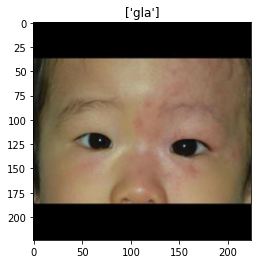

H:\先天性緑内障\dataset_250px\gla_ortho\2761_10.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_2.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_3.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_9.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_4.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_5.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_8.jpg 1
720
193
7


'\n#データセットの確認\nfor i, j in zip(train_list, train_list_label):\n    print(i,j)\n'

In [14]:
PX = 224 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.9,1.0)
#TRAIN_BRIGHTNESS_PARAM = 0.2
#TRAIN_CONTRAST_PARAM = 0.1
#TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

class Expand2square(object):
    """
    長方形の元画像を長辺を1辺とする正方形に貼り付け、空白を黒く塗りつぶす
    """
    def __init__(self, background_color):
        self.background_color = background_color

    def __call__(self, pil_img):
        width, height = pil_img.size
        if width == height:
            return pil_img
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), self.background_color)
            result.paste(pil_img, (0, (width-height)//2))
            return result
        else:
            result = Image.new(pil_img.mode, (height, height), self.background_color)
            result.paste(pil_img, (0, (height - width) // 2))
            return result

class SimpleImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform):
        self.transform = transform
        self.img_list = img_list
        self.label_list = label_list
        self.item_dict = {}
        self.age = []
        #print(img_list)
        #print(label_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor(self.label_list[idx])      
        return tensor_image, target

#画像読み込み時間削減のため、Expand2squareの処理は行っている
train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])




#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




#Defining early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    torch.backends.cudnn.benchmark = True

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print('-' * 10)

        ###################
        # train the model #
        ###################
        model.train() # Set model to training mode
        
        running_corrects, train_acc= 0, 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            
            # Runs the forward pass with autocasting.
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            """
            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            """

            # record training loss
            train_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)

            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """
        #print()   
        train_acc = running_corrects.item()/len(train_dataset)

        #####################
        # validate the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, val_acc= 0, 0

        # Iterate over data.
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
           
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            valid_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)
        val_acc = running_corrects.item()/len(val_dataset)



        #####################
        # test the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, test_acc= 0, 0

        # Iterate over data.
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            running_corrects += torch.sum(preds==labels)
        test_acc = running_corrects.item()/len(test_dataset)



        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train_acc:.5f}' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_acc: {val_acc:.5f}' +'\n'
                     f'test_acc: {test_acc:.5f}' + f'({running_corrects:.0f}/{len(test_dataset):.0f})') 

        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves,class_names):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == class_names[0]:
                  y_true.append(0)
            elif i == class_names[1]:
                  y_true.append(1)
            
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr, tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)
            
        k+=1

    plt.legend(loc="lower right")
    plt.show()
    return fig

def calculate_auc(label_list, model_pred_prob, class_names):
    y_true, y_score = [], []
    for i in label_list:
        if i == class_names[0]:
              y_true.append(0)
        elif i == class_names[1]:
              y_true.append(1)
            
    #それぞれの画像における陽性の確率についてリストを作成
    y_score = model_pred_prob

    print(y_true)
    print(len(y_true))
    print(y_score)
    print(len(y_score))

    fpr, tpr,thred = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: " +str(roc_auc))
    return(roc_auc, y_true, y_score)



###############################################
## Create model 
###############################################

model_ft = timm.create_model('efficientnetv2_rw_s', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)


#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))


##############################################
## Dataset and dataloader
##############################################
pt=4
fold=2
train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
test_list = testset[pt]
test_list_label = testset_label[pt]

#define dataset and dataloader
train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

# Make a grid from batch
inputs, classes = next(iter(test_loader))
print(classes)
out = torchvision.utils.make_grid(inputs)

class_names = ["cont", "gla"]
imshow(out, title=[class_names[x] for x in classes])

#データセットの確認
for i, j in zip(test_list, test_list_label):
    print(i,j)


##############################################
## Data augumentation
##############################################

TRAIN_RANDOM_ROTATION = 1
TRAIN_CROP_SCALE = (0.8,1.1)
PX = 224

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

print(len(train_list))
print(len(val_list))
print(len(test_list))

"""
#データセットの確認
for i, j in zip(train_list, train_list_label):
    print(i,j)
"""

In [ ]:

"""
------test_dataset[0]
  |
  |---train_dataset_gla[0]----0
  |                        |--1
  |                        |--2
  |                        |--3
  |                        |--4
  |---train_dataset_cont[0]----0
  |                         |--1
  |                         |--2
  |                         |--3
  |                         |--4
  |---val_dataset_gla[0]----0
  |                      |--1
  |                      |--2
  |                      |--3
  |                      |--4
  |---val_dataset_cont[0]----0
  |                       |--1
  |                       |--2
  |                       |--3
  |                       |--4
  |---test_dataset[1]
  ...

"""

'\n------test_dataset[0]\n  |\n  |---train_dataset_gla[0]----0\n  |                        |--1\n  |                        |--2\n  |                        |--3\n  |                        |--4\n  |---train_dataset_cont[0]----0\n  |                         |--1\n  |                         |--2\n  |                         |--3\n  |                         |--4\n  |---val_dataset_gla[0]----0\n  |                      |--1\n  |                      |--2\n  |                      |--3\n  |                      |--4\n  |---val_dataset_cont[0]----0\n  |                       |--1\n  |                       |--2\n  |                       |--3\n  |                       |--4\n  |---test_dataset[1]\n  ...\n\n'

In [15]:
train_dataset_gla, val_dataset_gla,train_dataset_cont, val_dataset_cont, testset, testset_label = [], [], [], [], [], []

#まずglaのデータセットから1人分を抜き出す（LeaveOneGroupOut)
# one group leave out 見本
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut
# 今回のケースでは、groupがIDに該当
logo = LeaveOneGroupOut()
logo.get_n_splits(gla_dataset_path, gla_classes, gla_id)
logo.get_n_splits(groups=gla_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(gla_dataset_path, gla_classes, gla_id):
    gla_dataset_path_remain, gla_dataset_path_test = gla_dataset_path[remain_index], gla_dataset_path[test_index]
    gla_classes_remain, gla_classes_test = gla_classes[remain_index], gla_classes[test_index]
    gla_id_remain, gla_id_test = gla_id[remain_index], gla_id[test_index]
    #print(gla_dataset_path, gla_dataset_path_test, gla_id_train, gla_id_test)
    #print("test: "+gla_id_test[0])
    #print("TRAIN:", remain_index, "TEST:", test_index)
    #print(gla_dataset_path_test[0])
    testset.append(gla_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(1, len(gla_dataset_path_test))))

    #抜き出した残りのglaについてStratified group 5-foldをかける
    # example of stratified group Kfold 見本
    # 今回のケースでは、groupがID、yがclassesに該当

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path_remain, gla_classes_remain, gla_id_remain):
        #print("TRAIN:", gla_classes_remain[train_idxs])
        #print("      ", gla_id_remain[train_idxs])
        #print("      ", gla_dataset_path_remain[train_idxs])
        #print(" TEST:", gla_classes_remain[val_idxs])
        #print("      ", gla_id_remain[val_idxs])
        #print("      ", gla_dataset_path_remain[val_idxs])
        train_miniset[m] = gla_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[gla] " + str(k))
    k+=1

    #control全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path, cont_classes, cont_id):
        #print("TRAIN:", cont_classes[train_idxs])
        #print("      ", cont_id[train_idxs])
        #print("      ", cont_dataset_path[train_idxs])
        #print(" TEST:", cont_classes[val_idxs])
        #print("      ", cont_id[val_idxs])
        #print("      ", cont_dataset_path[val_idxs])
        train_miniset[m] = cont_dataset_path[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

        
#print(len(train_dataset_gla))    
#print(len(val_dataset_gla))
#print(val_dataset_gla)
#print(len(train_dataset_cont))    
#print(len(val_dataset_cont))
#print(len(test_dataset))


#同じくcontのデータセットから1人分抜き出してLeaveOneGroupOutをする
logo = LeaveOneGroupOut()
logo.get_n_splits(cont_dataset_path, cont_classes, cont_id)
logo.get_n_splits(groups=cont_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(cont_dataset_path, cont_classes, cont_id):
    cont_dataset_path_remain, cont_dataset_path_test = cont_dataset_path[remain_index], cont_dataset_path[test_index]
    cont_classes_remain, cont_classes_test = cont_classes[remain_index], cont_classes[test_index]
    cont_id_remain, cont_id_test = cont_id[remain_index], cont_id[test_index]
    #print(cont_dataset_path_test[0])
    testset.append(cont_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(0, len(cont_dataset_path_test))))

    #抜き出した残りのcontについてStratified group 5-foldをかける

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path_remain, cont_classes_remain, cont_id_remain):
        train_miniset[m] = cont_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

    #gla全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path, gla_classes, gla_id):
        train_miniset[m] = gla_dataset_path[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[cont] "+ str(k))
    k+=1
        
print(len(train_dataset_gla))    
print(len(val_dataset_gla))
print(len(train_dataset_cont))    
print(len(val_dataset_cont))
print(len(testset))
print(len(testset_label))


720
720
720
720
720
720


#**Modules**

#**Training and evaluation**

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
tensor([1])


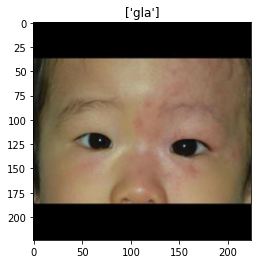

H:\先天性緑内障\dataset_250px\gla_ortho\2761_10.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_2.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_3.jpg 1
H:\先天性緑内障\dataset_250px\gla_ortho\2761_9.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_4.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_5.jpg 1
H:\先天性緑内障\dataset_250px\gla_eso\2761_8.jpg 1


In [16]:
###############################################
## Create model 
###############################################

model_ft = timm.create_model('efficientnetv2_rw_s', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)


#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))


##############################################
## Dataset and dataloader
##############################################
pt=4
fold=2
train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
test_list = testset[pt]
test_list_label = testset_label[pt]

#define dataset and dataloader
train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

# Make a grid from batch
inputs, classes = next(iter(test_loader))
print(classes)
out = torchvision.utils.make_grid(inputs)

class_names = ["cont", "gla"]
imshow(out, title=[class_names[x] for x in classes])

#データセットの確認
for i, j in zip(test_list, test_list_label):
    print(i,j)

In [17]:
############################
## Training
############################
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=10, num_epochs=200)

----------
Epoch: [  0/200] 
train_loss: 0.64147 train_acc: 0.70139
valid_loss: 0.60111 valid_acc: 0.72539
test_acc: 0.14286(1/7)
Validation loss decreased (inf --> 0.601112).  Saving model ...

----------
Epoch: [  1/200] 
train_loss: 0.36785 train_acc: 0.88750
valid_loss: 0.33880 valid_acc: 0.81347
test_acc: 0.28571(2/7)
Validation loss decreased (0.601112 --> 0.338804).  Saving model ...

----------
Epoch: [  2/200] 
train_loss: 0.15204 train_acc: 0.94028
valid_loss: 0.37657 valid_acc: 0.85492
test_acc: 0.00000(0/7)
EarlyStopping counter: 1 out of 10

----------
Epoch: [  3/200] 
train_loss: 0.07510 train_acc: 0.96806
valid_loss: 0.23962 valid_acc: 0.90155
test_acc: 0.57143(4/7)
Validation loss decreased (0.338804 --> 0.239625).  Saving model ...

----------
Epoch: [  4/200] 
train_loss: 0.06217 train_acc: 0.97917
valid_loss: 0.25812 valid_acc: 0.90674
test_acc: 0.71429(5/7)
EarlyStopping counter: 1 out of 10

----------
Epoch: [  5/200] 
train_loss: 0.06571 train_acc: 0.97639
valid

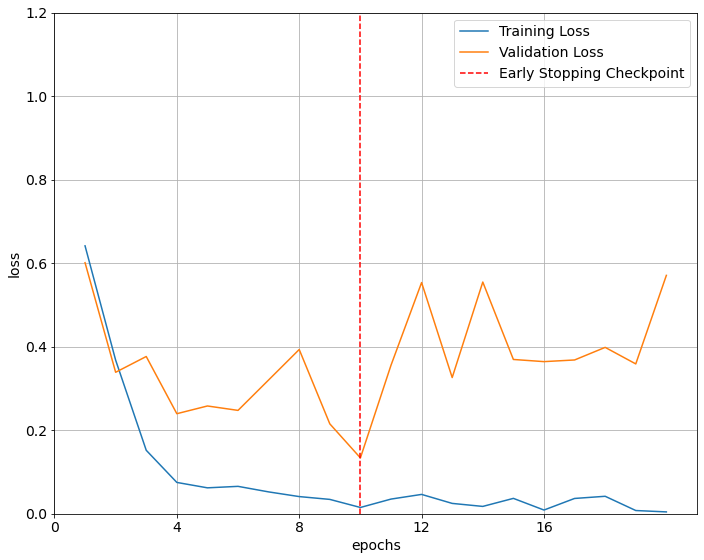

In [19]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
plt.rcParams["font.size"] = 14

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.xticks(np.arange(0, 20, 4) ) #start, end, 間隔
plt.yticks(np.arange(0, 1.4, 0.2) )
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show()
fig.savefig(r'C:\Users\ykita\Downloads\loss_plot.png', bbox_inches='tight', dpi=300)


In [21]:
model_ft.eval() # prep model for evaluation

targets, preds =[], []
for image_tensor, target in test_loader:  
      #target = target.squeeze(1)     
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)
      _, pred = torch.max(output, 1)  
      preds.append(int(pred))  #予測結果
      targets.append(int(target)) #ラベル

y_test = np.array(targets)
y_pred = np.array(preds)
print("label: ", y_test)
print("pred: ", y_pred)

label:  [1 1 1 1 1 1 1]
pred:  [0 1 1 1 0 0 1]


GradCAM (診断根拠の可視化)


In [22]:
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm

class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]   #c_scoreとは？？

    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      #print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      #print('Label: '+ label)
      return(image_name, label)



In [ ]:
# Split model in two parts
features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
 #最後の2層

#評価モードにする    
model_ft = model_ft.eval()
model_ft = model_ft.to(device)


classes = ["cont", "gla"]

#画像のパスを指定
#for j in range(1):
for j in range(len(test_dataset)):

    #元画像

    image = test_dataset[j][0]
    image = image.permute(1, 2, 0)

    img_tensor = test_dataset[j][0].unsqueeze(0)
    #Softmaxにかけたときの確率上位1つのpp(確率)とcc(class番号)を取得(tench→正常,goldfish→斜視)
    pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)

    #pとcを対にして入力
    for i, (p, c) in enumerate(zip(pp[0], cc[0])):  
        sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
        tmp = image.to('cpu').detach().numpy().copy()
        img = Image.fromarray((tmp*255).astype(np.uint8))
        #TensorをImageに変換
        sal = Image.fromarray(sal)
        sal = sal.resize(img.size, resample=Image.LINEAR)

        print()
        #print(img_path) #あとで参照しやすいように画像のパスを表示

        #plt.title('')
        print('label: '+classes[test_dataset[j][1]])
        print('pred:  '+'{}  {:.1f}%'.format(classes[c], 100*float(p)))
        #plt.title('pred:'+'{}: { .1f}%'.format(labels[c], 100*float(p)))        
        
        plt.figure(figsize=(15, 10))

        #グラフを1行2列に並べたうちの1番目
        plt.subplots_adjust(wspace=0,hspace=0)
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

        #元の画像を並べて表示
        image = test_dataset[j][0]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

#**Automated analysis**

In [ ]:
#保存用の空CSVを作成
pt_num = []
k=0
for data in testset:
    pt_num.append([k]*len(data))
    k+=1

img_num = []
for data in testset:
    img_num.append(list(range(len(data))))

patient_num = list(itertools.chain.from_iterable(pt_num))
img_num = list(itertools.chain.from_iterable(img_num))
patient_path = list(itertools.chain.from_iterable(testset))
patient_label = list(itertools.chain.from_iterable(testset_label))

df_result = pd.DataFrame(index=[],columns=[])
df_result = pd.DataFrame(index=[],columns=["pt_number","img_number", "path","label", "0","1","2","3","4", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"])
df_result["pt_number"] = patient_num
df_result["img_number"] = img_num
df_result["path"] = patient_path
df_result["label"] = patient_label

df_result.to_csv(r"H:\先天性緑内障\result_RepVGG20220726.csv",encoding="shift_jis", index=False)
df_result

,pt_number,img_number,path,label,0,1,2,3,4,prob_1,prob_2,prob_3,prob_4,prob_5
0,0,0,H:\先天性緑内障\dataset_for_article_250px_2\gla_orth...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,H:\先天性緑内障\dataset_for_article_250px_2\gla_orth...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,H:\先天性緑内障\dataset_for_article_250px_2\gla_orth...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,H:\先天性緑内障\dataset_for_article_250px_2\gla_orth...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,H:\先天性緑内障\dataset_for_article_250px_2\gla_exo\...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,718,0,H:\先天性緑内障\dataset_for_article_250px_2\cont_ort...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,719,0,H:\先天性緑内障\dataset_for_article_250px_2\cont_ort...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
921,720,0,H:\先天性緑内障\dataset_for_article_250px_2\cont_eso...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
922,721,0,H:\先天性緑内障\dataset_for_article_250px_2\cont_exo...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv

In [ ]:
#GradCAM
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm

class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]   #c_scoreとは？？

    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      #print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      #print('Label: '+ label)
      return(image_name, label)


def gradcam(model_ft, test_dataset, fold, save=False):
    # Split model in two parts
    features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
    classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
    #最後の2層

    #評価モードにする    
    model_ft = model_ft.eval()
    model_ft = model_ft.to(device)

    classes = ["cont", "gla"]

    #画像のパスを指定
    #for j in range(3):
    for j in range(len(test_dataset)):

        #元画像

        image = test_dataset[j][0]
        image = image.permute(1, 2, 0)

        img_tensor = test_dataset[j][0].unsqueeze(0)
        #Softmaxにかけたときの確率上位1つのpp(確率)とcc(class番号)を取得(tench→正常,goldfish→斜視)
        pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)

        #pとcを対にして入力
        for i, (p, c) in enumerate(zip(pp[0], cc[0])):  
            sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
            tmp = image.to('cpu').detach().numpy().copy()
            img = Image.fromarray((tmp*255).astype(np.uint8))
            #TensorをImageに変換
            sal = Image.fromarray(sal)
            sal = sal.resize(img.size, resample=Image.LINEAR)

            print()
            print('Pt: {}, image: {}'.format(pt, j))
            #print(img_path) #あとで参照しやすいように画像のパスを表示

            #plt.title('')
            print('label: '+classes[test_dataset[j][1]])
            print('pred:  '+'{}  {:.1f}%'.format(classes[c], 100*float(p)))
            #plt.title('pred:'+'{}: { .1f}%'.format(labels[c], 100*float(p)))        
            
            plt.figure(figsize=(15, 10))

            #グラフを1行2列に並べたうちの1番目
            plt.subplots_adjust(wspace=0,hspace=0)
            plt.subplot(1, 2, 1)
            plt.axis('off')
            plt.imshow(img)
            plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

            #元の画像を並べて表示
            image = test_dataset[j][0]
            image = image.permute(1, 2, 0)
            plt.subplot(1, 2, 2)
            plt.axis('off')
            plt.imshow(image)

            if save == True:
                plt.savefig(gradCAM_path+"/pt{}-fold{}-img{}-label-{}-pred-{}.png".format(pt,fold,j,classes[test_dataset[j][1]], classes[c]))

        plt.show()

#gradcam(model_ft, test_dataset, pt, save=False)

In [ ]:
#GradCAMなし

#Open reslut_csv
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)

time_start = time.perf_counter()

#pt,foldの初期値を入力（CSVに対応）
pt=0
fold=0



#Define Data Augumentation
TRAIN_RANDOM_ROTATION = 1
TRAIN_CROP_SCALE = (0.8,1.1)
PX = 224

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



for pt in range(pt,len(testset)): #指定したPtから開始
    for fold in list(range(5)):
        print("patient: "+str(pt)+", fold: "+str(fold))

        train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
        train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
        val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
        val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
        test_list = testset[pt]
        test_list_label = testset_label[pt]

        print(len(train_list))
        print(len(val_list))
        print(len(test_list))


        #define dataset and dataloader
        train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
        val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
        test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

        train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        # show sample image
        inputs, classes = next(iter(test_loader))
        print(classes)
        out = torchvision.utils.make_grid(inputs)
        class_names = ["cont", "gla"]
        imshow(out, title=[class_names[x] for x in classes])


        model_ft = create_RepVGG_A2(deploy=False)
        model_ft.load_state_dict(torch.load (pretrained_path))   
        num_ftrs = model_ft.linear.in_features
        model_ft.linear = nn.Linear(num_ftrs, 2)

        #GPU使用
        model_ft = model_ft.to(device)

        #損失関数を定義
        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        #https://blog.knjcode.com/adabound-memo/
        #https://pypi.org/project/torch-optimizer/
        from ranger_adabelief import RangerAdaBelief
        optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))
        model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=10, num_epochs=30)

        # visualize the loss as the network trained
        fig = plt.figure(figsize=(10,8))
        plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
        plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

        # find position of lowest validation loss
        minposs = valid_loss.index(min(valid_loss))+1 
        plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.ylim(0, 1.0) # consistent scale
        plt.xlim(0, len(train_loss)+1) # consistent scale
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        fig.savefig('loss_plot.png', bbox_inches='tight')

        #Prediction for testset
        model_ft.eval() # prep model for evaluation
        targets, probs, preds =[], [], []
        for image_tensor, target in test_loader:  
              #target = target.squeeze(1)     
              image_tensor = image_tensor.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model_ft(image_tensor)
              _, pred = torch.max(output, 1) 
            
              prob = nn.Softmax(dim=1)(output) #calculate probalility
              prob = prob[0][1].cpu().detach() #probalility of being positive
              print(prob)
              print(pred) 
              
              probs.append(prob)
              preds.append(int(pred))  #予測結果
              targets.append(int(target)) #ラベル

              gradcam(model_ft, image_tensor) 

        y_test = np.array(targets)
        y_pred = np.array(preds)
        y_prob = np.array(probs)
        print("label")
        print(y_test)
        print("pred")
        print(y_pred)
        print("prob")
        print(y_prob)

        #write result to df
        row = 0
        for i in testset[0:pt]:
            row += len(i)
        column = fold + 4
        df_result.iloc[row:row+len(y_pred), column] = y_pred
        column = fold + 9
        df_result.iloc[row:row+len(y_pred), column] = y_prob
        df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv        

        #経過時間を表示
        time_end = time.perf_counter()
        time_elapsed = (time_end - time_start)
        print("Elapsed time: "+str(time_elapsed))



In [ ]:
#GradCAMあり

# #GradCAM用のフォルダ作成
# shutil.rmtree(gradCAM_path)
# os.makedirs(gradCAM_path)
# for folder in ["TP","FP","FN","TN"]:
#     os.makedirs(gradCAM_path+"/"+str(folder))


#Open reslut_csv
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)

time_start = time.perf_counter()

#pt,foldの初期値を入力（CSVに対応）
pt=0
fold=0

#Define Data Augumentation
TRAIN_RANDOM_ROTATION = 1
TRAIN_CROP_SCALE = (0.8,1.1)
PX = 224

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



for pt in range(pt,len(testset)): #指定したPtから開始
    for fold in list(range(5)):
        print("patient: "+str(pt)+", fold: "+str(fold))

        train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
        train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
        val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
        val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
        test_list = testset[pt]
        test_list_label = testset_label[pt]

        print(len(train_list))
        print(len(val_list))
        print(len(test_list))


        #define dataset and dataloader
        train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
        val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
        test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

        train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        # show sample image
        inputs, classes = next(iter(test_loader))
        print(classes)
        out = torchvision.utils.make_grid(inputs)
        class_names = ["cont", "gla"]
        imshow(out, title=[class_names[x] for x in classes])


        model_ft = create_RepVGG_A2(deploy=False)
        model_ft.load_state_dict(torch.load (pretrained_path))   
        num_ftrs = model_ft.linear.in_features
        model_ft.linear = nn.Linear(num_ftrs, 2)

        #GPU使用
        model_ft = model_ft.to(device)

        #損失関数を定義
        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        #https://blog.knjcode.com/adabound-memo/
        #https://pypi.org/project/torch-optimizer/
        from ranger_adabelief import RangerAdaBelief
        optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))
        model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=10, num_epochs=30)

        # visualize the loss as the network trained
        fig = plt.figure(figsize=(10,8))
        plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
        plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

        # find position of lowest validation loss
        minposs = valid_loss.index(min(valid_loss))+1 
        plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.ylim(0, 1.0) # consistent scale
        plt.xlim(0, len(train_loss)+1) # consistent scale
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        fig.savefig('loss_plot.png', bbox_inches='tight')

        #Prediction for testset
        model_ft.eval() # prep model for evaluation
        targets, probs, preds =[], [], []
        for image_tensor, target in test_loader:  
              #target = target.squeeze(1)     
              image_tensor = image_tensor.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model_ft(image_tensor)
              _, pred = torch.max(output, 1) 
            
              prob = nn.Softmax(dim=1)(output) #calculate probalility
              prob = prob[0][1].cpu().detach() #probalility of being positive
              print(prob)
              print(pred) 
              
              probs.append(prob)
              preds.append(int(pred))  #予測結果
              targets.append(int(target)) #ラベル

              #tensorをPILに直す
              img = img_tensor.to('cpu').detach().numpy().copy()

        y_test = np.array(targets)
        y_pred = np.array(preds)
        y_prob = np.array(probs)
        print("label")
        print(y_test)
        print("pred")
        print(y_pred)
        print("prob")
        print(y_prob)

        #write result to df
        row = 0
        for i in testset[0:pt]:
            row += len(i)
        column = fold + 4
        df_result.iloc[row:row+len(y_pred), column] = y_pred
        column = fold + 9
        df_result.iloc[row:row+len(y_pred), column] = y_prob
        df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv 

        #GradCam
        gradcam(model_ft, test_dataset, fold,save=True )        

        #経過時間を表示
        time_end = time.perf_counter()
        time_elapsed = (time_end - time_start)
        print("Elapsed time: "+str(time_elapsed))

In [ ]:
targets

[1, 1, 1, 1, 1, 1, 1]

#**データセットをフォルダにコピー**

In [ ]:
"""
#データのパスを指定
pt=0
fold=0
train_list_gla = train_dataset_gla[pt][fold] 
train_list_cont = train_dataset_cont[pt][fold]
val_list_gla = val_dataset_gla[pt][fold]
val_list_cont = val_dataset_cont[pt][fold]

#パスを指定
train_gla = r"F:\先天性緑内障\データ引継ぎ\stratified\train\gla"
train_cont = r"F:\先天性緑内障\データ引継ぎ\stratified\train\cont"
val_gla = r"F:\先天性緑内障\データ引継ぎ\stratified\val\gla"
val_cont = r"F:\先天性緑内障\データ引継ぎ\stratified\val\cont"

orig_path = [train_list_gla, train_list_cont, val_list_gla, val_list_cont]
dst_path = [train_gla, train_cont, val_gla, val_cont]


for folder in dst_path:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True) 

for i in orig_path:
    print(len(i))


for orig_img_list, dst_folder in zip(orig_path, dst_path):
    if not orig_img_list:
        pass
    else:
        for origpath in orig_img_list:
            basepath = os.path.basename(origpath)
            dstpath = os.path.join(dst_folder, basepath)
            shutil.copyfile(origpath, dstpath)
            print(dstpath+ " copied!")
"""

#**結果のCSVを開く**

In [ ]:
pd.set_option('display.max_rows', 100)

with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)
df_result

In [ ]:
df_result

In [ ]:
######################################################################
# \\1546-2.jpg
# \\1546-2.jpg
#アンダーバーとハイフンが混ざっておりIDが誤って振られているので修正
######################################################################

k = 0
for i in range(len(df_result)):
    if k==0:
        pt_number = 0
        img_number = 0
    else:
        pt_path = df_result.loc[k, "path"]
        pt_id = re.split("[-_]", pt_path.rsplit("\\", maxsplit=1)[1])[0]
        pt_path_prev = df_result.loc[k-1, "path"]
        pt_id_prev = re.split("[-_]", pt_path_prev.rsplit("\\", maxsplit=1)[1])[0]
        if pt_id == pt_id_prev:
            pt_number = pt_number
            img_number += 1
        elif pt_id != pt_id_prev:
            pt_number += 1
            img_number = 0 

    df_result.loc[k, "pt_number"] = pt_number #同じ患者ではimg_numberを通し番号で割り振る
    df_result.loc[k, "img_number"] = img_number #同じ患者ではimg_numberを通し番号で割り振る
    k+= 1

df_result
 

In [ ]:
#変更されたdf_resultの目視確認用
df_result.to_csv(r"F:\先天性緑内障\result_Random_確認用.csv", encoding="shift_jis")

In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 


#sorted(sklearn.metrics.SCORERS.keys())


#indexの内容を確認
#print(df.columns.values.tolist())


FEATURE_COLS=df_result.columns.values[1:].tolist()

"""
FEATURE_COLS=[
 'cropped_A2',
 'cropped_B3']
"""

print(FEATURE_COLS)

# 訓練データとテストデータに分割する。
from sklearn.model_selection import train_test_split
# TODO:層別サンプリング train, test = train_test_split(df, test_size=0.20, stratify=df["町区分"], random_state=100)
train, test = train_test_split(df_result, test_size=0.20,random_state=100)

X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


c:\users\ykita\appdata\local\programs\python\python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
c:\users\ykita\appdata\local\programs\python\python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


['img_number', 'path', 'label', '0', '1', '2', '3', '4', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 

!pip install bayesian-optimization 
from bayes_opt import BayesianOptimization


#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, X)
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-2)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = X_test

    print("adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train)))
    print("adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test)))   
    #print("平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1)))) 
    print("MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)))
    print("MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)))
    print("RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))))
    print("RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test))) #better if result = 1.253

for i in FEATURE_COLS[8:13]:
    X_train = train[i]
    Y_train = train["label"]
    X_test = test[i]
    Y_test = test["label"]
    #print(str(i))
    #get_model_evaluations(X_train,Y_train,X_test,Y_test)
    #print("")


#後の解析のためにそれぞれの項目を戻しておく
X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


c:\users\ykita\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Accuracy: 0.9027027027027027
44 12 6 123
confusion matrix = 
 [[123   6]
 [ 12  44]]
Accuracy : 0.9027027027027027
Precision (true positive rate) : 0.88
Recall (sensitivity): 0.7857142857142857
Specificity : 0.9534883720930233
F1 score : 0.830188679245283
Area_under_ROC : 0.9504429678848283


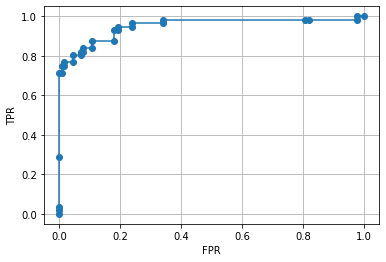

In [ ]:
import xgboost as xgb

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


"""XGBoost で二値分類するサンプルコード"""

X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


# XGBoost が扱うデータセットの形式に直す
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)
# 学習用のパラメータ
xgb_params = {
    # 二値分類問題
    'objective': 'binary:logistic',
    # 評価指標
    'eval_metric': 'logloss',
}
# モデルを学習する
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,  # 学習ラウンド数は適当
                )
# 検証用データが各クラスに分類される確率を計算する
Y_pred_proba = bst.predict(dtest)
# しきい値 0.5 で 0, 1 に丸める
Y_pred = np.where(Y_pred_proba > 0.5, 1, 0)
# 精度 (Accuracy) を検証する
acc = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc)


tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tp, fn, fp, tn)

def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)


print('confusion matrix = \n', confusion_matrix(Y_test, Y_pred))
print(f'Accuracy : {accuracy_score(Y_test, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y_test, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y_test, Y_pred)}')
print(f'Specificity : {specificity_score(Y_test, Y_pred)}')
print(f'F1 score : {f1_score(Y_test, Y_pred)}')


#ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)     
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
print(f'Area_under_ROC : {roc_auc_score(Y_test, Y_pred_proba)}')
#plt.savefig('plots/roc_curve.png')


fold 8
Accuracy: 0.920995670995671
171 60 13 680
confusion matrix = 
 [[680  13]
 [ 60 171]]
Accuracy : 0.920995670995671
Precision (true positive rate) : 0.9293478260869565
Recall (sensitivity): 0.7402597402597403
Specificity : 0.9812409812409812
F1 score : 0.8240963855421688
Area_under_ROC : 0.9242018203057165

fold 9
Accuracy: 0.8971861471861472
162 69 26 667
confusion matrix = 
 [[667  26]
 [ 69 162]]
Accuracy : 0.8971861471861472
Precision (true positive rate) : 0.8617021276595744
Recall (sensitivity): 0.7012987012987013
Specificity : 0.9624819624819625
F1 score : 0.7732696897374702
Area_under_ROC : 0.9289493575207861

fold 10
Accuracy: 0.9047619047619048
157 74 14 679
confusion matrix = 
 [[679  14]
 [ 74 157]]
Accuracy : 0.9047619047619048
Precision (true positive rate) : 0.9181286549707602
Recall (sensitivity): 0.6796536796536796
Specificity : 0.9797979797979798
F1 score : 0.7810945273631841
Area_under_ROC : 0.9558291636213714

fold 11
Accuracy: 0.8603896103896104
125 106 23 67

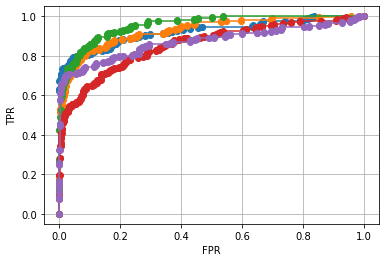

In [ ]:
import statistics

accuracy = []
precision = []
recall = []
specificity = []
f1score = []
area_u_ROC = []


for i in range(8,13):
    print("fold",i)
    X = df_result[FEATURE_COLS[i]]
    Y = df_result["label"]

    Y_pred_proba = X
    Y_pred = np.where(Y_pred_proba >= 0.5, 1, 0)

    acc = accuracy_score(Y, Y_pred)
    print('Accuracy:',acc)

    tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
    print(tp, fn, fp, tn)

    def specificity_score(label, pred):
        tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
        return tn / (tn + fp)


    print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
    print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
    print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
    print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
    print(f'Specificity : {specificity_score(Y, Y_pred)}')
    print(f'F1 score : {f1_score(Y, Y_pred)}')

    #ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)     
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    print(f'Area_under_ROC : {roc_auc_score(Y, Y_pred_proba)}')
    #plt.savefig('plots/roc_curve.png')

    accuracy.append(accuracy_score(Y, Y_pred))
    precision.append(precision_score(Y, Y_pred))
    recall.append(recall_score(Y, Y_pred))
    specificity.append(specificity_score(Y, Y_pred))
    f1score.append(f1_score(Y, Y_pred))
    area_u_ROC.append(roc_auc_score(Y, Y_pred_proba))

    print("")

print("Result of 5-fold crossvalidation")
print("accuracy: ", statistics.mean(accuracy))
print("precision: ", statistics.mean(precision))
print("recall (sensitivity): ", statistics.mean(recall))
print("specifiity: ", statistics.mean(specificity))
print("f1_score: ", statistics.mean(f1score))
print("area_u_ROC: ", statistics.mean(area_u_ROC))


threshold 0.01
Result of 5-fold crossvalidation
accuracy: 0.6731601731601732±0.08086885405398866
precision: 0.4356626926853674±0.06581621121448358
recall (sensitivity):0.9255411255411256±0.03142630547685114
specifiity: 0.589033189033189±0.10200703658895607
f1_score: 0.5906477034967345±0.06514954299374678
area_u_ROC: 0.907835310432713±0.0411768003800548

threshold 0.02
Result of 5-fold crossvalidation
accuracy: 0.7021645021645022±0.0785604628503516
precision: 0.4617739133530772±0.07245091629456472
recall (sensitivity):0.9116883116883117±0.032020328827198075
specifiity: 0.6323232323232323±0.10163757556132084
f1_score: 0.6103923559212727±0.06658675550722531
area_u_ROC: 0.907835310432713±0.038821859701735406

threshold 0.03
Result of 5-fold crossvalidation
accuracy: 0.7240981240981241±0.07957354884699765
precision: 0.48466125285332184±0.0810121654847253
recall (sensitivity):0.901010101010101±0.036177138545112376
specifiity: 0.6651274651274651±0.10480753402839468
f1_score: 0.62673178340423

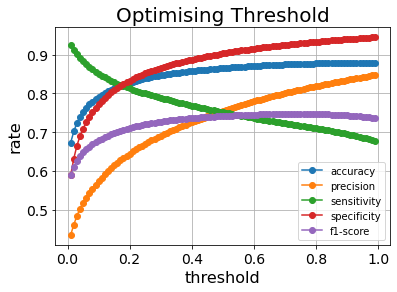

In [ ]:
#5-foldの平均に関してbest thresholdを探索
import statistics

accuracy = []
precision = []
recall = []
specificity = []
f1score = []
area_u_ROC = []

threshold_list, acc_list, precision_list, sensitivity_list, specificity_list, f1_list = [],[],[],[],[],[]
thred_list = [i/100 for i in range(1, 100, 1)] #Threshold 0.01-0.15を探索
for thred in thred_list:
    for i in range(8,13):

        X = df_result[FEATURE_COLS[i]]
        Y = df_result["label"]

        Y_pred_proba = X
        Y_pred = np.where(Y_pred_proba >= thred, 1, 0)

        acc = accuracy_score(Y, Y_pred)

        tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()


        def specificity_score(label, pred):
            tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
            return tn / (tn + fp)

        accuracy.append(accuracy_score(Y, Y_pred))
        precision.append(precision_score(Y, Y_pred))
        recall.append(recall_score(Y, Y_pred))
        specificity.append(specificity_score(Y, Y_pred))
        f1score.append(f1_score(Y, Y_pred))
        area_u_ROC.append(roc_auc_score(Y, Y_pred_proba))

    print("")
    print("threshold", thred)
    print("Result of 5-fold crossvalidation")
    print(f"accuracy: {statistics.mean(accuracy)}±{statistics.stdev(accuracy)}")
    print(f"precision: {statistics.mean(precision)}±{statistics.stdev(precision)}")
    print(f"recall (sensitivity):{statistics.mean(recall)}±{statistics.stdev(recall)}")
    print(f"specifiity: {statistics.mean(specificity)}±{statistics.stdev(specificity)}")
    print(f"f1_score: {statistics.mean(f1score)}±{statistics.stdev(f1score)}")
    print(f"area_u_ROC: {statistics.mean(area_u_ROC)}±{statistics.stdev(area_u_ROC)}")
    threshold_list.append(thred_list)
    acc_list.append(statistics.mean(accuracy))
    precision_list.append(statistics.mean(precision))
    sensitivity_list.append(statistics.mean(recall))
    specificity_list.append(statistics.mean(specificity))
    f1_list.append(statistics.mean(f1score))

#plot
x_datas, acc_datas, precision_datas, sensitivity_datas, specificity_datas, f1_datas = [],[],[],[],[],[]
x_datas = thred_list
acc_datas =  acc_list
precision_datas = precision_list
sensitivity_datas = sensitivity_list
specificity_datas = specificity_list
f1_datas = f1_list

plt.plot(x_datas, acc_datas, marker = 'o', label='accuracy')
plt.plot(x_datas, precision_datas, marker = 'o', label='precision')
plt.plot(x_datas, sensitivity_datas, marker = 'o', label='sensitivity')
plt.plot(x_datas, specificity_datas, marker = 'o', label='specificity')
plt.plot(x_datas, f1_datas, marker = 'o', label='f1-score')


#フォントサイズをまとめて変更する場合
#plt.rcParams["font.size"] = 18

plt.title('Optimising Threshold', fontsize = 20)
plt.xlabel('threshold', fontsize = 16)
plt.ylabel('rate', fontsize = 16)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
#5-foldの多数決で判定したとき

#画像毎の評価におけるbest thresholdを探索
import statistics

num_thresh = 1 #陽性判定が何個以上で陽性と取るか
def judgement(df,threshold, row):
    df_temp = df.iloc[row,:]
    label = df_temp["label"]
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0) #df_tempのprobのうちthresholdを超えていたら1、下回れば0の行列
    #print(pred)
    #pred = np.where(np.count_nonzero(pred == 1) >= np.count_nonzero(pred = 0), 1, 0).tolist() #陽性と陰性のどちらかが多いかの多数決をとる
    pred = np.where(np.count_nonzero(pred == 1) >= num_thresh, 1, 0).tolist() #陽性判定が一定数以上で陽性とする
    proba = sorted(prob.ravel())[-(num_thresh)]
    return pred, proba


# accuracy = []
# precision = []
# recall = []
# specificity = []
# f1score = []
# area_u_ROC = []

threshold_list, acc_list, precision_list, sensitivity_list, specificity_list, f1_list = [],[],[],[],[],[]
thred_list = [i/100 for i in range(1, 100, 1)] #Threshold 0.01-0.15を探索
for thred in thred_list:

    pred_list, proba_list = [],[]
    for row in range(len(df_result)):
        threshold = thred
        pred, proba = judgement(df_result,threshold, row)
        pred_list.append(pred)
        proba_list.append(proba)

    Y = df_result["label"]
    Y_pred = pred_list
    Y_proba = proba_list

    tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()


    def specificity_score(label, pred):
        tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
        return tn / (tn + fp)

    # accuracy.append(accuracy_score(Y, Y_pred))
    # precision.append(precision_score(Y, Y_pred))
    # recall.append(recall_score(Y, Y_pred))
    # specificity.append(specificity_score(Y, Y_pred))
    # f1score.append(f1_score(Y, Y_pred))
    # area_u_ROC.append(roc_auc_score(Y, Y_pred_proba))

    print("")
    print("threshold", thred)
    print("Result of 5-fold crossvalidation")
    print(f"accuracy: {accuracy_score(Y, Y_pred)}")
    print(f"precision: {precision_score(Y, Y_pred)}")
    print(f"recall (sensitivity):{recall_score(Y, Y_pred)}")
    print(f"specifiity: {specificity_score(Y, Y_pred)}")
    print(f"f1_score: {f1_score(Y, Y_pred)}")
    print(f"area_u_ROC: {roc_auc_score(Y, Y_proba)}")
    threshold_list.append(thred)
    acc_list.append(accuracy_score(Y, Y_pred))
    precision_list.append(precision_score(Y, Y_pred))
    sensitivity_list.append(recall_score(Y, Y_pred))
    specificity_list.append(specificity_score(Y, Y_pred))
    f1_list.append(f1_score(Y, Y_pred))

#plot
x_datas, acc_datas, precision_datas, sensitivity_datas, specificity_datas, f1_datas = [],[],[],[],[],[]
x_datas = thred_list
acc_datas =  acc_list
precision_datas = precision_list
sensitivity_datas = sensitivity_list
specificity_datas = specificity_list
f1_datas = f1_list

plt.plot(x_datas, acc_datas, marker = 'o', label='accuracy')
plt.plot(x_datas, precision_datas, marker = 'o', label='precision')
plt.plot(x_datas, sensitivity_datas, marker = 'o', label='sensitivity')
plt.plot(x_datas, specificity_datas, marker = 'o', label='specificity')
plt.plot(x_datas, f1_datas, marker = 'o', label='f1-score')


#フォントサイズをまとめて変更する場合
#plt.rcParams["font.size"] = 18

plt.title('Optimising Threshold', fontsize = 20)
plt.xlabel('threshold', fontsize = 16)
plt.ylabel('rate', fontsize = 16)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

Area_under_ROC : 0.9454595428621403


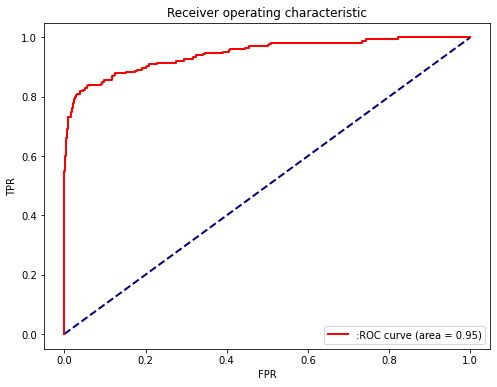

In [ ]:
num_thresh = 1 #陽性判定が何個以上で陽性と取るか
def judgement(df,threshold, row):
    df_temp = df.iloc[row,:]
    label = df_temp["label"]
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0) #df_tempのprobのうちthresholdを超えていたら1、下回れば0の行列
    #print(pred)
    #pred = np.where(np.count_nonzero(pred == 1) >= np.count_nonzero(pred = 0), 1, 0).tolist() #陽性と陰性のどちらかが多いかの多数決をとる
    pred = np.where(np.count_nonzero(pred == 1) >= num_thresh, 1, 0).tolist() #陽性判定が一定数以上で陽性とする
    proba = sorted(prob.ravel())[-(num_thresh)]
    return pred, proba



#Draw ROC curve
pred_list, proba_list = [],[]
for row in range(len(df_result)):
    threshold = thred
    pred, proba = judgement(df_result,threshold, row)
    pred_list.append(pred)
    proba_list.append(proba)

Y = df_result["label"]
Y_pred = pred_list
Y_proba = proba_list

#ROC curve
fpr, tpr, thresholds = roc_curve(Y, Y_proba)    

fig = plt.figure(figsize=(8.0, 6.0))
lw = 2 #線の太さ
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
plt.rcParams["font.family"] = "Helvetica"   # 使用するフォント
plt.rcParams["font.size"] = 10  

#plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.grid()

plt.plot(fpr, tpr, color=ycolor[0],lw=lw, label= ':ROC curve (area = %0.2f)' % roc_auc_score(Y, Y_proba))
plt.legend(loc="lower right")

print(f'Area_under_ROC : {roc_auc_score(Y, Y_proba)}')
plt.savefig(r"C:\Users\ykita\Downloads\ROC_vote.png", format="png", dpi=350)



In [ ]:
prob = df_result.iloc[10,:][["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten()
prob

array([0.0973363742232322, 0.4021570682525635, 0.441888153553009,
       0.0853318870067596, 0.0593914128839969], dtype=object)

In [ ]:
df_temp = df_result.iloc[300,:]
label = df_temp["label"]
prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
print(prob)
pred = np.where(prob > 0.1, 1, 0)
print(pred)
#pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist() #正解と不正解のどちらかが多いかの多数決をとる
pred = np.where(np.count_nonzero(pred == label) >= 3, 1, 0).tolist() #正解数が一定数以上で正解とする
print(pred)

[2.3219030481413935e-05 0.4110097289085388 2.534555096644908e-05
 9.875698015093803e-05 0.0577685981988906]
[0 1 0 0 0]
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fold 8
fold 9
fold 10
fold 11
fold 12


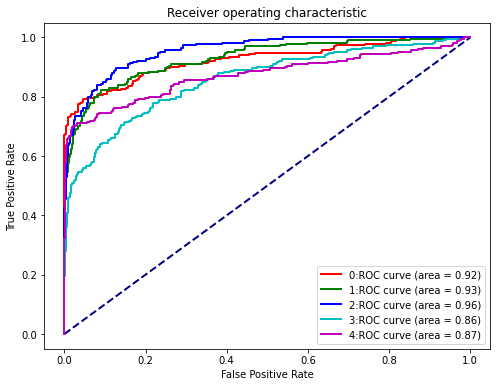

In [ ]:
#ROC curve描き直し

def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")
    plt.rcParams["font.family"] = "Helvetica"   # 使用するフォント
    plt.rcParams["font.size"] = 10 

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == 1:
                  y_true.append(1)
            elif i == 0:
                  y_true.append(0)
            
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr, tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)
            
        k+=1

    plt.legend(loc="lower right")

    plt.savefig(r"C:\Users\ykita\Downloads\ROC_5fold.png", format="png", dpi=350)

    plt.show()

    return fig



label_list_list, model_pred_prob_list, Y_TRUE, Y_SCORE = [],[],[],[]

for i in range(8,13):
    print("fold",i)
    X = df_result[FEATURE_COLS[i]]
    Y = df_result["label"]

    Y_pred_proba = X
    Y_pred = np.where(Y_pred_proba >= 0.5, 1, 0)

    label_list_list.append(Y)
    model_pred_prob_list.append(Y_pred_proba)

#Draw ROC curve
roc_label_list = list(range(5))
fig = Draw_roc_curve(label_list_list, model_pred_prob_list, roc_label_list, len(label_list_list))


In [ ]:
#論文用にROCカーブを細かくする
def calculate_fpr_tpr_5fold(df_result, threshold, fold):
    label_list, pred_list = [], []
    number_of_img = len(df_result)
    for i in range(len(df_result)):
        threshold = threshold
        label = df_result.loc[i,"label"]

        #予測確率がthresholdを超えていたらpred=1とする
        if df_result.loc[i, "prob_"+str(fold)] >= threshold:
            pred = 1
        else:
            pred = 0

        label_list.append(label)
        pred_list.append(pred)

    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr


#ざっくり10点でROC curveを描いてみる
thred_list = [i/10000 for i in range(10000)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

#グラフの外形を作成
fig = plt.figure(figsize=(8.0, 6.0))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色

plt.rcParams["font.family"] = "Helvetica"   # 使用するフォント
plt.rcParams["font.size"] = 10 

roc_label_list = list(range(5))
for fold in range(0,5,1):
    print(fold)
    fpr_list, tpr_list = [], []
    for i in thred_list:
        fpr, tpr = calculate_fpr_tpr_5fold(df_result, i, fold+1)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    roc_auc = auc(fpr_list, tpr_list)
    plt.plot(fpr_list, tpr_list, color=ycolor[fold],lw=lw, label= str(roc_label_list[fold])+':ROC curve (area = %0.2f)' % roc_auc)

plt.legend()

plt.savefig(r"C:\Users\ykita\Downloads\ROC_5fold.png", format="png", dpi=300) #画像を高解像度で保存

plt.show()




#**患者ごとの正答率**

In [ ]:
pd.set_option('display.max_rows', 1000)
df_result

In [ ]:
def Draw_roc_curve_patients(fpr_list, tpr_list, thred_list):

    #グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = "r"     # プロットの色
    plt.legend(loc="lower right")

    roc_auc = auc(fpr_list, tpr_list)

    plt.plot(fpr_list, tpr_list, color=ycolor,lw=lw, label= 'ROC curve (area = %0.2f)' % roc_auc)
        

    plt.legend(loc="lower right")
    plt.show()
    return fig


#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    #prob = np.round(prob, decimals=3) #probabilityの数字を小数点3桁までにする（ROC curveに斜めの線が入るのを防ぐため）
    pred = np.where(prob > threshold, 1, 0)
    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist()
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
    return int(pred)


def calculate_fpr_tpr(pt_gla, pt_cont, df_result, threshold):
    label_list, pred_list = [], []
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


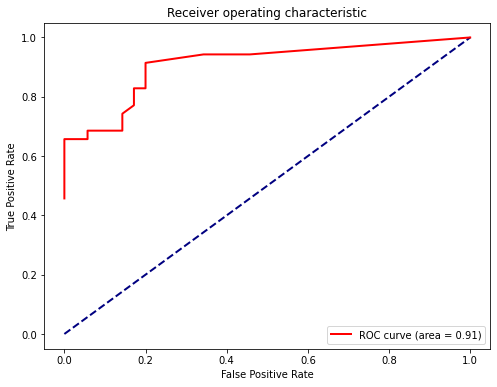

pt_gla:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
pt_cont:  [76, 132, 136, 155, 170, 181, 197, 201, 216, 222, 311, 315, 319, 320, 321, 324, 354, 371, 373, 403, 431, 447, 489, 518, 533, 536, 554, 560, 566, 573, 595, 619, 637, 667, 704]


In [ ]:
df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

#ざっくり10点でROC curveを描いてみる
thred_list = [i/100 for i in range(100)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

#print(fpr_list)
#print(tpr_list)
#print(thred_list)

Draw_roc_curve_patients(fpr_list, tpr_list, thred_list)

print("pt_gla: ", pt_gla)
print("pt_cont: ", pt_cont)

In [ ]:
#################################################
threshold = 0.05 #判定基準。ここは先に入力しておく
random.seed(100)
#################################################

df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0)
    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist() #正解と不正解のどちらかが多いかの多数決をとる
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TP", "FN")
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TN", "FP")
    return pred

for i in pt_gla:
    pt_number = i
    label = 1
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

for i in pt_cont:
    pt_number = i
    label = 0
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

df_pt_analysis

Y = df_pt_analysis["label"].tolist()
Y_pred = df_pt_analysis["pred"].tolist()

print(Y)
print(Y_pred)

tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
#print(tp, fn, fp, tn)
print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
print(f'Specificity : {specificity_score(Y, Y_pred)}')
print(f'F1 score : {f1_score(Y, Y_pred)}')
print("")


##Calcurate the Youden's J static
#https://ichi.pro/fukinkona-bunrui-no-saiteki-nashi-kiichi-97327858631315
tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
thresholds = np.array(thred_list)

youdenJ = tpr - fpr

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

#Find the optimal threshold
# Find the optimal threshold
index = np.argmax(youdenJ)

thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
print("")

##Youden's indexをもとにした正答率を計算
#################################################
threshold = thresholdOpt #判定基準
#################################################

for i in pt_gla:
    pt_number = i
    label = 1
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

for i in pt_cont:
    pt_number = i
    label = 0
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

df_pt_analysis

Y = df_pt_analysis["label"].tolist()
Y_pred = df_pt_analysis["pred"].tolist()

#print(Y)
#print(Y_pred)

tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
#print(tp, fn, fp, tn)
print("Using Youden's index")
print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
print(f'Specificity : {specificity_score(Y, Y_pred)}')
print(f'F1 score : {f1_score(Y, Y_pred)}')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
confusion matrix = 
 [[29  6]
 [ 5 30]]
Accuracy : 0.8428571428571429
Precision (true positive rate) : 0.8333333333333334
Recall (sensitivity): 0.8571428571428571
Specificity : 0.8285714285714286
F1 score : 0.8450704225352113

Best Threshold: 0.03 with Youden J statistic: 0.8552
FPR: 0.2, TPR: 0.9143

Using Youden's index
confusion matrix = 
 [[25 10]
 [ 3 32]]
Accuracy : 0.8142857142857143
Precision (true positive rate) : 0.7619047619047619
Recall (sensitivity): 0.9142857142857143
Specificity : 0.7142857142857143
F1 score : 0.8311688311688312


#**患者毎のROC curveを出す**

In [ ]:
####################
#アンサンブルで解析#
####################


def Draw_roc_curve_patients(fpr_list, tpr_list, thred_list):

    #グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = "r"     # プロットの色
    plt.legend(loc="lower right")

    roc_auc = auc(fpr_list, tpr_list)

    plt.plot(fpr_list, tpr_list, color=ycolor,lw=lw, label= 'ROC curve (area = %0.2f)' % roc_auc)
        

    plt.legend(loc="lower right")
    plt.show()
    return fig


#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    #prob = np.round(prob, decimals=3) #probabilityの数字を小数点3桁までにする（ROC curveに斜めの線が入るのを防ぐため）
    pred = np.where(prob > threshold, 1, 0)
    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist()
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
    return int(pred)


def calculate_fpr_tpr(pt_gla, pt_cont, df_result, threshold):
    label_list, pred_list = [], []
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr
 


df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

#ざっくり10点でROC curveを描いてみる
thred_list = [i/100 for i in range(100)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

#print(fpr_list)
#print(tpr_list)
#print(thred_list)

Draw_roc_curve_patients(fpr_list, tpr_list, thred_list)

print("pt_gla: ", pt_gla)
print("pt_cont: ", pt_cont)




In [ ]:
#点数を増やして描画し直し
#※ものすごく時間かかる
thred_list = [i/100000 for i in range(100000)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

#print(fpr_list)
#print(tpr_list)
#print(thred_list)

Draw_roc_curve_patients(fpr_list, tpr_list, thred_list)

In [ ]:
################
#foldごとに解析#
################

#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number, fold):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"][fold]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    #prob = np.round(prob, decimals=3) #probabilityの数字を小数点3桁までにする（ROC curveに斜めの線が入るのを防ぐため）
    pred = np.where(prob > threshold, 1, 0)
    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist()
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
    return int(pred)


def calculate_fpr_tpr_5fold(pt_gla, pt_cont, df_result, threshold, fold):
    label_list, pred_list = [], []
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i, fold)
        label_list.append(label)
        pred_list.append(pred)
    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i, fold)
        label_list.append(label)
        pred_list.append(pred)
    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr



df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

#ざっくり10点でROC curveを描いてみる
thred_list = [i/1000000 for i in range(1000000)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

#グラフの外形を作成
fig = plt.figure(figsize=(8.0, 6.0))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色

plt.rcParams["font.family"] = "Helvetica"   # 使用するフォント
plt.rcParams["font.size"] = 10 

roc_label_list = list(range(5))
for fold in range(0,5,1):
    print(fold)
    fpr_list, tpr_list = [], []
    for i in thred_list:
        fpr, tpr = calculate_fpr_tpr_5fold(pt_gla, pt_cont, df_result, i, fold)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    roc_auc = auc(fpr_list, tpr_list)
    plt.plot(fpr_list, tpr_list, color=ycolor[fold],lw=lw, label= str(roc_label_list[fold])+':ROC curve (area = %0.2f)' % roc_auc)

plt.legend()

plt.savefig(r"C:\Users\ykita\Downloads\ROC_perPt.png", format="png", dpi=300) #画像を高解像度で保存

plt.show()

#**人力判定との比較**

##使用データ
- 緑内障群  
各患者よりランダムに1枚ずつ選択（30枚）

- コントロール群  
ランダムに患者を選択し1枚ずつ選択（30枚）  
内斜視:正位:外斜視 = 1:5:4


##検討方法
- AI群  
one subject out stratified 5-fold crossvalidation法  
5-foldの判定の多数決でpredを決定  
Thresholdの決定にはYouden J staticを使用  

- 人力群  
緑内障のスペシャリスト 3名
一般眼科医  3名  
先天性緑内障の特徴について説明（角膜混濁、眼球あるいは角膜の拡大）  
緑内障群、コントロール群の両方に斜視患者がいることを説明  
画像を見てもらって判定  

- 検討項目  
感度、特異度、陽性的中率、F_value

In [ ]:
pd.set_option('display.max_rows', 100)

with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)
df_result

FileNotFoundError: ignored

In [ ]:
def Draw_roc_curve_patients(fpr_list, tpr_list, thred_list):

    #グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = "r"     # プロットの色
    plt.legend(loc="lower right")

    roc_auc = auc(fpr_list, tpr_list)

    plt.plot(fpr_list, tpr_list, color=ycolor,lw=lw, label= 'ROC curve (area = %0.2f)' % roc_auc)
        

    plt.legend(loc="lower right")
    plt.show()
    return fig

def calculate_fpr_tpr(pt_gla, pt_cont, df_result, threshold):
    label_list, pred_list = [], []
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr

def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)

In [ ]:
###############################
#患者ごとの正解率を計算
#※結果の良いseedを探索
###############################

import xgboost as xgb

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


seed_list = []
f1_list = []
specificity_list =  []
sensitivity_list = []

#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    #df_temp = df_temp.sample(n=1) #画像が複数ある症例では、1つの画像をランダムに選択する
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0)

    #print(pt_number)
    #print(df_temp)
    #print("")

    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist() #正解と不正解のどちらかが多いかの多数決をとる
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TP", "FN")
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TN", "FP")
    return pred


for seed in list(range(1200, 1300, 1)):
    random.seed(seed) #結果の良いrandom seedを探索する

    df_pt_analysis = pd.DataFrame(index=[],columns=[])
    df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

    #gla群
    pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

    #cont群（数をgla群に揃えるよう、ランダムにピックアップ）
    pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
    pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

    ##Calcurate the Youden's J static
    #https://ichi.pro/fukinkona-bunrui-no-saiteki-nashi-kiichi-97327858631315
    thred_list = [i/100 for i in range(1, 15, 1)] #Threshold 0.01-0.15を探索
    fpr_list = []
    tpr_list = []
    cutoff_criterions = []

    for i in thred_list:
        fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    tpr = np.array(tpr_list)
    fpr = np.array(fpr_list)
    thresholds = np.array(thred_list)

    youdenJ = tpr - fpr
    
    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))

    #Find the optimal threshold
    # Find the optimal threshold
    index = np.argmax(youdenJ)





    thresholdOpt = round(thresholds[index], ndigits = 4)
    youdenJOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)

    ##Youden's indexをもとにした正答率を計算
    #################################################
    threshold = thresholdOpt #判定基準
    #################################################
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

    Y = df_pt_analysis["label"].tolist()
    Y_pred = df_pt_analysis["pred"].tolist()

    tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
    #print(tp, fn, fp, tn)
    """
    print(f'Random_seed : {str(seed)}')
    print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
    print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
    print(f'Specificity : {specificity_score(Y, Y_pred)}')
    print(f'F1 score : {f1_score(Y, Y_pred)}')
    print("")
    """

    seed_list.append(seed)
    f1_list.append(f1_score(Y, Y_pred))
    specificity_list.append(specificity_score(Y, Y_pred))
    sensitivity_list.append(recall_score(Y, Y_pred))

print(seed_list)
print(f1_list)

max_value = max(f1_list)
idx = f1_list.index(max_value)
print("best_seed: ", seed_list[idx])
print("best_f1_score: ", f1_list[idx])


df_f1 = pd.DataFrame(columns = [])
df_f1["seed"] = seed_list
df_f1["f1_score"] = f1_list
df_f1["specificity"] = specificity_list
df_f1["sensitivity"] = sensitivity_list
df_f1

[1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299]
[0.8787878787878788, 0.904109589041096, 0.9166666666666667, 0.8648648648648648, 0.9166666666666667, 0.8125, 0.8533333333333333, 0.888888888888889, 0.8529411764705883, 0.904109589041096, 0.8533333333333333, 0.8656716417910447, 0.8125, 0.8767123287671234, 0.8923076923076922, 0.8767123287671234, 0.8253968253968255, 0.8387096774193549, 0.8656716417910447, 0.8767123287671234, 0.9142857142857143, 0.888

,seed,f1_score,specificity,sensitivity
0,1200,0.878788,0.942857,0.828571
1,1201,0.904110,0.857143,0.942857
2,1202,0.916667,0.885714,0.942857
3,1203,0.864865,0.800000,0.914286
4,1204,0.916667,0.885714,0.942857
5,1205,0.812500,0.914286,0.742857
6,1206,0.853333,0.771429,0.914286
7,1207,0.888889,0.857143,0.914286
8,1208,0.852941,0.885714,0.828571
9,1209,0.904110,0.857143,0.942857


In [ ]:
#################################################
#患者毎の正答率を表示
#ここは先に入力しておく
random.seed(1288)
#################################################

df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))


#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    #df_temp = df_temp.sample(n=1, random_state=random_state) #画像が複数ある症例では、1つの画像をランダムに選択する
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0)

    #print(pt_number)
    #print(df_temp)
    #print("")

    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist() #正解と不正解のどちらかが多いかの多数決をとる
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TP", "FN")
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TN", "FP")
    return pred


##Calcurate the Youden's J static
#https://ichi.pro/fukinkona-bunrui-no-saiteki-nashi-kiichi-97327858631315
thred_list = [i/100 for i in range(1, 30, 1)] #Threshold 0.01-0.30を探索
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
thresholds = np.array(thred_list)

youdenJ = tpr - fpr

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

#Find the optimal threshold
# Find the optimal threshold
index = np.argmax(youdenJ)

thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
print("")

##Youden's indexをもとにした正答率を計算
#################################################
threshold = thresholdOpt #判定基準
#################################################

for i in pt_gla:
    pt_number = i
    label = 1
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

for i in pt_cont:
    pt_number = i
    label = 0
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]


Y = df_pt_analysis["label"].tolist()
Y_pred = df_pt_analysis["pred"].tolist()

#print(Y)
#print(Y_pred)

tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
#print(tp, fn, fp, tn)
print("Using Youden's index")
print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
print(f'Specificity : {specificity_score(Y, Y_pred)}')
print(f'F1 score : {f1_score(Y, Y_pred)}')

Best Threshold: 0.03 with Youden J statistic: 0.9143
FPR: 0.0857, TPR: 0.9143

Using Youden's index
confusion matrix = 
 [[32  3]
 [ 3 32]]
Accuracy : 0.9142857142857143
Precision (true positive rate) : 0.9142857142857143
Recall (sensitivity): 0.9142857142857143
Specificity : 0.9142857142857143
F1 score : 0.9142857142857143


In [ ]:
df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

#ざっくり10点でROC curveを描いてみる
thred_list = [i/100 for i in range(100)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

#print(fpr_list)
#print(tpr_list)
#print(thred_list)

Draw_roc_curve_patients(fpr_list, tpr_list, thred_list)

print("pt_gla: ", pt_gla)
print("pt_cont: ", pt_cont)

In [ ]:
#点数を増やして描画し直し
#※ものすごく時間かかる
thred_list = [i/100000 for i in range(100000)]
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

#print(fpr_list)
#print(tpr_list)
#print(thred_list)

Draw_roc_curve_patients(fpr_list, tpr_list, thred_list)

In [ ]:
#1症例1枚ずつ選択した場合の正解率を計算
#1症例中の画像の選択 -> random_state を探索
#controlの画像選択 -> random.seedで固定

##############################
random.seed(1288) #ここは先に入力しておく
##############################

seed_list = []
f1_list = []
specificity_list =  []
sensitivity_list = []

#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    df_temp = df_temp.sample(n=1, random_state = seed) #画像が複数ある症例では、1つの画像をランダムに選択する
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0)

    #print(pt_number)
    #print(df_temp)
    #print("")

    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist() #正解と不正解のどちらかが多いかの多数決をとる
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TP", "FN")
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TN", "FP")
    return pred


for seed in list(range(0, 100, 1)):
    df_pt_analysis = pd.DataFrame(index=[],columns=[])
    df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred"])

    #gla群
    pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

    #cont群（数をgla群に揃えるよう、ランダムにピックアップ）
    pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
    pt_cont = sorted(random.sample(pt_cont, len(pt_gla)))

    ##Calcurate the Youden's J static
    #https://ichi.pro/fukinkona-bunrui-no-saiteki-nashi-kiichi-97327858631315
    thred_list = [i/100 for i in range(1, 15, 1)] #Threshold 0.01-0.15を探索
    fpr_list = []
    tpr_list = []
    cutoff_criterions = []

    for i in thred_list:
        fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    tpr = np.array(tpr_list)
    fpr = np.array(fpr_list)
    thresholds = np.array(thred_list)

    youdenJ = tpr - fpr

    #Find the optimal threshold
    # Find the optimal threshold
    index = np.argmax(youdenJ)

    thresholdOpt = round(thresholds[index], ndigits = 4)
    youdenJOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)

    ##Youden's indexをもとにした正答率を計算
    #################################################
    threshold = thresholdOpt #判定基準
    #################################################
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred = judgement(df_result, label, threshold, i)
        df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred]

    Y = df_pt_analysis["label"].tolist()
    Y_pred = df_pt_analysis["pred"].tolist()

    tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
    #print(tp, fn, fp, tn)
    """
    print(f'Random_seed : {str(seed)}')
    print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
    print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
    print(f'Specificity : {specificity_score(Y, Y_pred)}')
    print(f'F1 score : {f1_score(Y, Y_pred)}')
    print("")
    """

    seed_list.append(seed)
    f1_list.append(f1_score(Y, Y_pred))
    specificity_list.append(specificity_score(Y, Y_pred))
    sensitivity_list.append(recall_score(Y, Y_pred))

print(seed_list)
print(f1_list)

max_value = max(f1_list)
idx = f1_list.index(max_value)
print("best_seed: ", seed_list[idx])
print("best_f1_score: ", f1_list[idx])


df_f1 = pd.DataFrame(columns = [])
df_f1["seed"] = seed_list
df_f1["f1_score"] = f1_list
df_f1["specificity"] = specificity_list
df_f1["sensitivity"] = sensitivity_list
df_f1

In [ ]:
#################################################
#ここは先に入力しておく
random.seed(1288)
random_state = 51
#################################################


df_pt_analysis = pd.DataFrame(index=[],columns=[])
df_pt_analysis = pd.DataFrame(index=[],columns=["pt_number","number_of_img","threshold", "label", "pred", "path"])

#gla群
pt_gla = df_result.loc[df_result["label"]==1]["pt_number"].drop_duplicates().tolist()

#cont群（数をgla群に揃えるよう、ランダムにピックアップ）
pt_cont= df_result.loc[df_result["label"]==0]["pt_number"].drop_duplicates().tolist()
pt_cont = sorted(random.sample(pt_cont, len(pt_gla))) #random stateにより変動する


#ProbがThresholdをこえているものをカウントする
def judgement(df_result, label, threshold, pt_number):
    df_temp = df_result.loc[df_result["pt_number"]==pt_number] #患者の画像リストをすべて抜き出す
    df_temp = df_temp.sample(n=1, random_state=random_state) #画像が複数ある症例では、1つの画像をランダムに選択する
    prob = df_temp[["prob_1","prob_2", "prob_3", "prob_4", "prob_5"]].values.flatten() #probalilityの項目をnumpyに変換して1次元に変換
    pred = np.where(prob > threshold, 1, 0)
    path = df_temp["path"].tolist()[0]

    #print(pt_number)
    #print(df_temp)
    #print("")

    #print(pred)
    if label ==1:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 1, 0).tolist() #正解と不正解のどちらかが多いかの多数決をとる
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TP", "FN")
    elif label ==0:
        pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), 0, 1).tolist()
        #pred = np.where(np.count_nonzero(pred == label) >= np.count_nonzero(pred != label), "TN", "FP")
    return pred, path

def calculate_fpr_tpr(pt_gla, pt_cont, df_result, threshold):
    label_list, pred_list = [], []
    for i in pt_gla:
        pt_number = i
        label = 1
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred, path = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    for i in pt_cont:
        pt_number = i
        label = 0
        threshold = threshold
        number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
        pred, path = judgement(df_result, label, threshold, i)
        label_list.append(label)
        pred_list.append(pred)
    tn, fp, fn, tp = confusion_matrix(label_list, pred_list).ravel()
    fpr, tpr = fp/(tn+fp), tp/(tp+fn)
    return fpr, tpr

##Calcurate the Youden's J static
#https://ichi.pro/fukinkona-bunrui-no-saiteki-nashi-kiichi-97327858631315
thred_list = [i/100 for i in range(1, 30, 1)] #Threshold 0.01-0.30を探索
fpr_list = []
tpr_list = []
cutoff_criterions = []

for i in thred_list:
    fpr, tpr = calculate_fpr_tpr(pt_gla, pt_cont, df_result, i)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
thresholds = np.array(thred_list)

youdenJ = tpr - fpr

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

#Find the optimal threshold
# Find the optimal threshold
index = np.argmax(youdenJ)

thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
print("")

##Youden's indexをもとにした正答率を計算
#################################################
threshold = thresholdOpt #判定基準
#################################################

for i in pt_gla:
    pt_number = i
    label = 1
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred, path = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred, path]

for i in pt_cont:
    pt_number = i
    label = 0
    threshold = threshold
    number_of_img = df_result["pt_number"][df_result["pt_number"] == i].count()
    pred, path = judgement(df_result, label, threshold, i)
    df_pt_analysis.loc[i,:] = [pt_number, number_of_img, threshold, label, pred, path]


Y = df_pt_analysis["label"].tolist()
Y_pred = df_pt_analysis["pred"].tolist()

#print(Y)
#print(Y_pred)

tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
#print(tp, fn, fp, tn)
print("Using Youden's index")
print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
print(f'Specificity : {specificity_score(Y, Y_pred)}')
print(f'F1 score : {f1_score(Y, Y_pred)}')

Best Threshold: 0.03 with Youden J statistic: 0.8999
FPR: 0.0857, TPR: 0.8857

Using Youden's index
confusion matrix = 
 [[32  3]
 [ 4 31]]
Accuracy : 0.9
Precision (true positive rate) : 0.9117647058823529
Recall (sensitivity): 0.8857142857142857
Specificity : 0.9142857142857143
F1 score : 0.8985507246376812


In [ ]:
df_pt_analysis

In [ ]:
df_pt_analysis_orig = df_pt_analysis.copy()
path = df_pt_analysis_orig["path"][0]
a = path.split("\\")
print("path: {}".format(path))
print("split: {}".format(a))

path: F:\先天性緑内障\dataset_for_article_250px_2\gla_ortho\1546_7.jpg
split: ['F:', '先天性緑内障', 'dataset_for_article_250px_2', 'gla_ortho', '1546_7.jpg']


#人力評価用のCSVを作成

AI：パス、label、AIによる予測

ヒト（一人ずつ）：画像番号のみ

In [ ]:
import datetime

df_pt_analysis_shuffle = df_pt_analysis.sample(frac=1, random_state=1).reset_index() #df_pt_analysisをシャッフル（random_state指定）し、インデックスを振り直す

#AIの判定結果をCSVに転記
df_AI = df_pt_analysis_shuffle[["path", "label", "pred"]]
df_AI = df_AI.rename(columns={'pred': 'AI'}) #pred --> AIにrename
df_AI["path"]= df_AI["path"].str.replace("250px", "orig")
dst_path = r"F:\先天性緑内障//Human_pred//AI_"+str(datetime.datetime.today().date())+".csv"
df_AI.to_csv(dst_path, encoding="shift_jis") #AIによる予測結果をAI_日付の名前で保存
print("saving list tocsv... '{}'".format(dst_path))

#evaluatorの数だけ評価用csvファイルを作成する
evaluator_list = ["usui", "okazaki", "fujino", "shimojyo"]  
for name in evaluator_list:
    df_human_pred = pd.DataFrame(index=[x for x in range(len(df_pt_analysis))], columns=["judgement"]) 
    df_human_pred.to_csv(r"F:\先天性緑内障//Human_pred"+"//"+name+"_"+str(datetime.datetime.today().date())+".csv", encoding="shift_jis")  #evaluatorの名前_日付の名前で保存
print("making csv files for human evaluation... {}".format(evaluator_list))

saving list tocsv... 'F:\先天性緑内障//Human_pred//AI_2022-05-09.csv'
making csv files for human evaluation... ['usui', 'okazaki', 'fujino', 'shimojyo']


In [ ]:
df_AI

In [ ]:
#判定用PDFファイルの作成
import cv2
import shutil
from PIL import Image, ImageDraw, ImageFont


save_path = r"F:\先天性緑内障//Human_pred//images"

#save_pathがあれば削除して新しく作り直す
try:
    shutil.rmtree(save_path)
    os.makedirs(save_path)
except FileNotFoundError:
    os.makedirs(save_path)
    pass


#CSVに対応する画像のパスを取得
img_path_list = []
for i in range(len(df_AI)):
    img_path = df_AI.iloc[i,0]
    img_path_list.append(img_path)
#print(img_path_list)


#画像リサイズのモジュール(500px四方)
def convert(in_path, out_path, number):
    img = Image.open(in_path)
    img_new = expand2square(img, (0, 0, 0)).resize((500, 500))
    img_new2 = drawNumber(img_new, number)
    img_new.save(out_path)

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width-height)//2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, (0, (height - width) // 2))
        return result

def drawNumber(pil_img, number):
    text = str(number)
    imagesize = pil_img.size
    draw = ImageDraw.Draw(pil_img)  # ImageDrawオブジェクトを作成
    font = ImageFont.truetype("arial.ttf", 64)  # フォントを指定、64はサイズでピクセル単位
    size = font.getsize(text)
    # 画像右下に'Sampleと表示' #FFFは文字色（白）
    draw.text((imagesize[0] - size[0], imagesize[1] - size[1]), text, font=font, fill='#FFF')
    return pil_img

k=0
for i in range(len(img_path_list)):
    in_path = img_path_list[i]
    out_path = save_path+"//"+str(k)+".jpg"
    convert(in_path, out_path, k)
    k+=1

print("Image pickup done!!")

['F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\8345.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\gla_ortho\\8294_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\9427..jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\2703.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\gla_ortho\\8425_2.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_ortho\\434_4.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\254_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\1049_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\2449_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\gla_ortho\\8882_2.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\gla_ortho\\2004_34.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_ortho\\118_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_exo\\2675_2.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_ortho\\1024_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_orig_2\\cont_ortho\\1392_1.jpg', 'F:\\先天性緑内障\\dataset_for_article_o

In [ ]:
#作成した画像をPDF fileにまとめる
import os
import img2pdf
from PIL import Image # img2pdfと一緒にインストールされたPillowを使います


pdfFileName = r"F://先天性緑内障//Human_pred//images"+str(datetime.datetime.today().date())+".pdf"
imgpath = r"F://先天性緑内障//Human_pred//images//*"
ext = ".jpg"
 
with open(pdfFileName, "wb") as files:
  files.write(img2pdf.convert([i for i in glob.glob(imgpath) if i.endswith(ext)]))

In [ ]:
#作成したpdfにパスワードをかける
import PyPDF2

src_pdf = PyPDF2.PdfFileReader(pdfFileName)
pass_pdf = pdfFileName
password = '6903'    #password

dst_pdf = PyPDF2.PdfFileWriter()
dst_pdf.cloneReaderDocumentRoot(src_pdf)

d = {key: src_pdf.documentInfo[key] for key in src_pdf.documentInfo.keys()}
dst_pdf.addMetadata(d)

dst_pdf.encrypt(password)

with open(pass_pdf, 'wb') as f:
    dst_pdf.write(f)